
# CRYPTO TRADING WITH SOCIAL SENTIMENT INTEGRATION

Research Notebook: Social Sentiment as Alpha Factor
Based on Stefan Jansen's ML4T Framework + NLP Sentiment Analysis

Purpose: Quantify Twitter/X FOMO sentiment and integrate with technical
         indicators to predict crypto price movements

Key Innovation: Sentiment is a LEADING indicator for retail-heavy assets
                (Jansen, 2020)

Structure:
1. Environment Setup & Authentication
2. Data Collection (CCXT + Twitter/Reddit)
3. Sentiment Analysis (NLP Pipeline)
4. Feature Engineering (Technical + Sentiment)
5. Model Training (XGBoost with Sentiment Features)
6. Backtesting & Performance Analysis
7. Results Export to Google Drive



## SECTION 1: ENVIRONMENT SETUP

In [11]:
print("\n[1.1] Installing dependencies...")
import sys
!{sys.executable} -m pip install -q ccxt vaderSentiment transformers torch --upgrade
!{sys.executable} -m pip install -q xgboost lightgbm scikit-learn ta pandas numpy matplotlib seaborn
!{sys.executable} -m pip install -q praw  # Reddit API (optional)

print("✓ Dependencies installed successfully!")


[1.1] Installing dependencies...
✓ Dependencies installed successfully!


In [4]:
# Mount Google Drive for persistent storage
print("\n[1.2] Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Create project directory
import os
from pathlib import Path

PROJECT_DIR = Path('/content/drive/MyDrive/Crypto_Sentiment_ML')
PROJECT_DIR.mkdir(exist_ok=True, parents=True)

DATA_DIR = PROJECT_DIR / 'data'
MODELS_DIR = PROJECT_DIR / 'models'
RESULTS_DIR = PROJECT_DIR / 'results'

for dir_path in [DATA_DIR, MODELS_DIR, RESULTS_DIR]:
    dir_path.mkdir(exist_ok=True)

print(f"✓ Project directory: {PROJECT_DIR}")


[1.2] Mounting Google Drive...
Mounted at /content/drive
✓ Project directory: /content/drive/MyDrive/Crypto_Sentiment_ML


In [12]:
# Core imports
import pandas as pd
import numpy as np
import ccxt
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
import json

print("\n✓ Environment ready!")


✓ Environment ready!


## SECTION 2: CONFIGURATION

In [13]:
# Trading Configuration
CONFIG = {
    'crypto_pairs': ['BTC/USDT', 'ETH/USDT', 'SOL/USDT'],
    'exchange': 'kraken',  # Alternative: 'kraken', 'bitfinex', 'coinbase'
    'timeframe': '1h',  # 1 hour candles
    'lookback_days': 180,  # 6 months of data
    'train_split': 0.8,  # 80-20 train-test split

    # Sentiment Configuration
    'sentiment_lookback_hours': 24,  # Aggregate sentiment over 24h
    'twitter_keywords': ['bitcoin', 'btc', 'ethereum', 'eth', 'crypto', 'solana', 'sol'],
    'sentiment_model': 'vader',  # 'vader' or 'transformers'

    # Model Configuration
    'model_type': 'xgboost',
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.05,
}

# Display config
print(json.dumps(CONFIG, indent=2))

{
  "crypto_pairs": [
    "BTC/USDT",
    "ETH/USDT",
    "SOL/USDT"
  ],
  "exchange": "kraken",
  "timeframe": "1h",
  "lookback_days": 180,
  "train_split": 0.8,
  "sentiment_lookback_hours": 24,
  "twitter_keywords": [
    "bitcoin",
    "btc",
    "ethereum",
    "eth",
    "crypto",
    "solana",
    "sol"
  ],
  "sentiment_model": "vader",
  "model_type": "xgboost",
  "n_estimators": 200,
  "max_depth": 5,
  "learning_rate": 0.05
}


## SECTION 3: DATA COLLECTION - CRYPTO PRICES (CCXT)

In [14]:
def fetch_crypto_ohlcv(exchange_id, symbol, timeframe, since_days):
    """
    Fetch OHLCV data using CCXT

    Args:
        exchange_id: Exchange name (e.g., 'binance')
        symbol: Trading pair (e.g., 'BTC/USDT')
        timeframe: Candle interval (e.g., '1h')
        since_days: Number of days to look back

    Returns:
        DataFrame with OHLCV data
    """
    print(f"\nFetching {symbol} from {exchange_id}...")

    # Initialize exchange
    exchange_class = getattr(ccxt, exchange_id)
    exchange = exchange_class({'enableRateLimit': True})

    # Calculate start timestamp
    since = exchange.parse8601(
        (datetime.now() - timedelta(days=since_days)).isoformat()
    )

    # Fetch all historical data
    all_candles = []

    while True:
        try:
            candles = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)

            if not candles:
                break

            all_candles.extend(candles)

            # Update since to last candle timestamp
            since = candles[-1][0] + 1

            # Check if we've reached current time
            if candles[-1][0] >= exchange.milliseconds() - exchange.parse_timeframe(timeframe) * 1000:
                break

            print(f"  Fetched {len(all_candles)} candles...", end='\r')

        except Exception as e:
            print(f"\n Error: {e}")
            break

    # Convert to DataFrame
    df = pd.DataFrame(
        all_candles,
        columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
    )

    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    df.drop('timestamp', axis=1, inplace=True)
    df['symbol'] = symbol.replace('/', '_')

    print(f"\n✓ Fetched {len(df)} candles for {symbol}")
    print(f"  Range: {df.index.min()} to {df.index.max()}")

    return df


# Fetch data for all pairs
print("\n[3.1] Fetching market data from CCXT...")

market_data_list = []

for pair in CONFIG['crypto_pairs']:
    df = fetch_crypto_ohlcv(
        CONFIG['exchange'],
        pair,
        CONFIG['timeframe'],
        CONFIG['lookback_days']
    )
    market_data_list.append(df)

# Combine all pairs
market_data = pd.concat(market_data_list, axis=0)
market_data.sort_index(inplace=True)

# Save raw market data
market_data.to_csv(DATA_DIR / 'raw_market_data.csv')
print(f"\n✓ Market data saved: {len(market_data)} records")

# Display sample
print("\nSample market data:")
print(market_data.head())


[3.1] Fetching market data from CCXT...

Fetching BTC/USDT from kraken...

✓ Fetched 721 candles for BTC/USDT
  Range: 2026-01-19 16:00:00 to 2026-02-18 16:00:00

Fetching ETH/USDT from kraken...

✓ Fetched 721 candles for ETH/USDT
  Range: 2026-01-19 16:00:00 to 2026-02-18 16:00:00

Fetching SOL/USDT from kraken...

✓ Fetched 721 candles for SOL/USDT
  Range: 2026-01-19 16:00:00 to 2026-02-18 16:00:00

✓ Market data saved: 2163 records

Sample market data:
                         open      high       low     close      volume  \
date                                                                      
2026-01-19 16:00:00  93059.40  93406.50  92993.10  93324.90    2.595766   
2026-01-19 16:00:00   3216.23   3226.43   3213.15   3221.53   37.684204   
2026-01-19 16:00:00    133.56    134.50    133.54    134.46  404.150370   
2026-01-19 17:00:00  93310.00  93365.50  93156.40  93230.70    0.964274   
2026-01-19 17:00:00   3223.22   3224.42   3217.93   3217.93   40.829903   

           

## SECTION 4: SOCIAL SENTIMENT COLLECTION
**TWITTER API LIMITATION:**

Twitter/X API now requires paid access ($100+/month).

ALTERNATIVE SOLUTIONS:
1. snscrape (web scraping - may break)
2. Reddit API (free, rich crypto discussions)
3. Simulated sentiment data (for demonstration)

For production use, integrate:
- Twitter API v2 (paid)
- LunarCrush API (crypto-specific sentiment)
- Santiment API (on-chain + social data)

In [15]:
def collect_reddit_sentiment(subreddit_list, keywords, lookback_days):
    """
    Collect posts from crypto subreddits as proxy for social sentiment

    Args:
        subreddit_list: List of subreddits to scrape
        keywords: Keywords to filter posts
        lookback_days: Days to look back

    Returns:
        DataFrame with posts and timestamps
    """
    print("\n[4.1] Collecting Reddit data...")

    try:
        import praw

        # Initialize Reddit API (read-only, no auth needed)
        reddit = praw.Reddit(
            client_id='your_client_id',  # Register at reddit.com/prefs/apps
            client_secret='your_client_secret',
            user_agent='crypto_sentiment_research'
        )

        posts_data = []

        for subreddit_name in subreddit_list:
            print(f"  Scraping r/{subreddit_name}...")
            subreddit = reddit.subreddit(subreddit_name)

            for post in subreddit.new(limit=1000):
                post_time = datetime.fromtimestamp(post.created_utc)

                if (datetime.now() - post_time).days > lookback_days:
                    break

                posts_data.append({
                    'date': post_time,
                    'title': post.title,
                    'text': post.selftext,
                    'score': post.score,
                    'num_comments': post.num_comments,
                    'subreddit': subreddit_name
                })

        return pd.DataFrame(posts_data)

    except Exception as e:
        print(f" Reddit API error: {e}")
        return None


# Option 1: Try Reddit (free)
# reddit_data = collect_reddit_sentiment(
#     ['CryptoCurrency', 'Bitcoin', 'ethereum', 'solana'],
#     CONFIG['twitter_keywords'],
#     CONFIG['lookback_days']
# )

# Option 2: Generate simulated sentiment data for demonstration
print("\n[4.2] Generating simulated sentiment data...")
print("(In production, replace with real Twitter/Reddit API)")



[4.2] Generating simulated sentiment data...
(In production, replace with real Twitter/Reddit API)


In [16]:
def generate_simulated_sentiment(market_data, volatility_factor=0.3):
    """
    Generate realistic sentiment data correlated with price movements
    Simulates FOMO/FUD cycles based on returns
    """
    sentiment_data = []

    for symbol in market_data['symbol'].unique():
        symbol_data = market_data[market_data['symbol'] == symbol].copy()

        # Calculate returns
        symbol_data['returns'] = symbol_data['close'].pct_change()

        # Generate sentiment correlated with price action (with lag)
        np.random.seed(42)

        for idx, row in symbol_data.iterrows():
            # Base sentiment: correlated with recent returns
            recent_return = symbol_data.loc[:idx, 'returns'].tail(24).mean()

            # Add noise and FOMO amplification
            base_sentiment = np.tanh(recent_return * 50)  # Scale returns to [-1, 1]
            noise = np.random.normal(0, volatility_factor)
            sentiment_score = np.clip(base_sentiment + noise, -1, 1)

            # Generate multiple "posts" per hour (simulate social activity)
            num_posts = np.random.poisson(10)  # Average 10 posts per hour

            sentiment_data.append({
                'date': idx,
                'symbol': symbol,
                'sentiment_score': sentiment_score,
                'num_posts': num_posts,
                'fomo_score': max(0, sentiment_score),  # Only positive sentiment
                'fud_score': abs(min(0, sentiment_score))  # Only negative sentiment
            })

    return pd.DataFrame(sentiment_data)


sentiment_data = generate_simulated_sentiment(market_data)

# Save sentiment data
sentiment_data.to_csv(DATA_DIR / 'sentiment_data.csv', index=False)
print(f"✓ Generated {len(sentiment_data)} sentiment records")

print("\nSample sentiment data:")
print(sentiment_data.head(10))

✓ Generated 2163 sentiment records

Sample sentiment data:
                 date    symbol  sentiment_score  num_posts  fomo_score  \
0 2026-01-19 16:00:00  BTC_USDT              NaN         12    0.000000   
1 2026-01-19 17:00:00  BTC_USDT        -0.091905          6    0.000000   
2 2026-01-19 18:00:00  BTC_USDT         0.404689         14    0.404689   
3 2026-01-19 19:00:00  BTC_USDT         0.194402          7    0.194402   
4 2026-01-19 20:00:00  BTC_USDT         0.047081          9    0.047081   
5 2026-01-19 21:00:00  BTC_USDT        -0.605776         11    0.000000   
6 2026-01-19 22:00:00  BTC_USDT        -0.337783         10    0.000000   
7 2026-01-19 23:00:00  BTC_USDT        -0.477757          7    0.000000   
8 2026-01-20 00:00:00  BTC_USDT        -0.203757         11    0.000000   
9 2026-01-20 01:00:00  BTC_USDT        -0.004010          8    0.000000   

   fud_score  
0   0.000000  
1   0.091905  
2   0.000000  
3   0.000000  
4   0.000000  
5   0.605776  
6   0.3377

## SECTION 5: SENTIMENT ANALYSIS (NLP)

In [17]:
def analyze_sentiment_vader(text):
    """
    Analyze sentiment using VADER (Valence Aware Dictionary and sEntiment Reasoner)
    Optimized for social media text
    """
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)

    return scores['compound']  # Range: -1 (negative) to +1 (positive)

In [18]:
def analyze_sentiment_transformer(text):
    """
    Analyze sentiment using transformer model (more accurate but slower)
    """
    from transformers import pipeline

    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="finiteautomata/bertweet-base-sentiment-analysis"
    )

    result = sentiment_pipeline(text[:512])[0]  # Truncate to 512 tokens

    # Convert to score
    score_map = {'POS': 1.0, 'NEU': 0.0, 'NEG': -1.0}
    return score_map.get(result['label'], 0.0) * result['score']


# For simulated data, sentiment is already computed
# In production, apply NLP here:
# sentiment_data['sentiment_score'] = sentiment_data['text'].apply(analyze_sentiment_vader)

print("✓ Sentiment analysis complete")
print(f"\nSentiment distribution:")
print(sentiment_data['sentiment_score'].describe())

✓ Sentiment analysis complete

Sentiment distribution:
count    2160.000000
mean       -0.020168
std         0.309197
min        -0.977961
25%        -0.231647
50%        -0.023460
75%         0.191693
max         0.852806
Name: sentiment_score, dtype: float64


## SECTION 6: FEATURE ENGINEERING

In [19]:
def calculate_technical_indicators(df):
    """
    Calculate technical indicators using TA library
    """
    import ta

    df = df.copy()

    # Trend Indicators
    df['sma_20'] = ta.trend.sma_indicator(df['close'], window=20)
    df['ema_12'] = ta.trend.ema_indicator(df['close'], window=12)
    df['ema_26'] = ta.trend.ema_indicator(df['close'], window=26)

    # Momentum Indicators
    df['rsi'] = ta.momentum.rsi(df['close'], window=14)
    df['macd'] = ta.trend.macd_diff(df['close'])

    # Volatility Indicators
    df['bb_high'] = ta.volatility.bollinger_hband(df['close'])
    df['bb_low'] = ta.volatility.bollinger_lband(df['close'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])

    # Volume Indicators
    df['volume_sma'] = ta.volume.volume_weighted_average_price(
        df['high'], df['low'], df['close'], df['volume']
    )

    return df

In [20]:
def aggregate_sentiment_features(market_df, sentiment_df, window_hours=24):
    """
    Aggregate sentiment data to match market timeframe
    """
    sentiment_features = []

    for symbol in market_df['symbol'].unique():
        symbol_market = market_df[market_df['symbol'] == symbol].copy()
        symbol_sentiment = sentiment_df[sentiment_df['symbol'] == symbol].copy()
        symbol_sentiment.set_index('date', inplace=True)

        for idx in symbol_market.index:
            # Get sentiment data for past window_hours
            window_start = idx - pd.Timedelta(hours=window_hours)
            window_sentiment = symbol_sentiment.loc[window_start:idx]

            if len(window_sentiment) > 0:
                sentiment_features.append({
                    'date': idx,
                    'symbol': symbol,
                    'sentiment_mean': window_sentiment['sentiment_score'].mean(),
                    'sentiment_std': window_sentiment['sentiment_score'].std(),
                    'sentiment_max': window_sentiment['sentiment_score'].max(),
                    'sentiment_min': window_sentiment['sentiment_score'].min(),
                    'fomo_intensity': window_sentiment['fomo_score'].mean(),
                    'fud_intensity': window_sentiment['fud_score'].mean(),
                    'social_volume': window_sentiment['num_posts'].sum(),
                    'sentiment_momentum': window_sentiment['sentiment_score'].diff().mean()
                })
            else:
                # No sentiment data available - fill with neutral
                sentiment_features.append({
                    'date': idx,
                    'symbol': symbol,
                    'sentiment_mean': 0,
                    'sentiment_std': 0,
                    'sentiment_max': 0,
                    'sentiment_min': 0,
                    'fomo_intensity': 0,
                    'fud_intensity': 0,
                    'social_volume': 0,
                    'sentiment_momentum': 0
                })

    return pd.DataFrame(sentiment_features)

In [22]:
print("\n[6.1] Calculating technical indicators...")


[6.1] Calculating technical indicators...


In [21]:
# Calculate technical indicators for each symbol
technical_data_list = []

for symbol in market_data['symbol'].unique():
    symbol_data = market_data[market_data['symbol'] == symbol].copy()
    symbol_data = calculate_technical_indicators(symbol_data)
    technical_data_list.append(symbol_data)

technical_data = pd.concat(technical_data_list, axis=0)

print("✓ Technical indicators calculated")

✓ Technical indicators calculated


In [23]:
print("\n[6.2] Aggregating sentiment features...")

sentiment_features = aggregate_sentiment_features(
    technical_data,
    sentiment_data,
    CONFIG['sentiment_lookback_hours']
)

print(f"✓ Sentiment features aggregated: {len(sentiment_features)} records")


[6.2] Aggregating sentiment features...
✓ Sentiment features aggregated: 2163 records


In [24]:
print("\n[6.3] Merging features...")

# Merge technical and sentiment data
feature_data = technical_data.reset_index().merge(
    sentiment_features,
    on=['date', 'symbol'],
    how='left'
)

feature_data.set_index('date', inplace=True)

# Fill any remaining NaN values
feature_data.fillna(method='ffill', inplace=True)
feature_data.dropna(inplace=True)


[6.3] Merging features...


In [25]:
# Calculate target variable: forward 24h return
print("\n[6.4] Creating target variable (24h forward return)...")

feature_data['target'] = feature_data.groupby('symbol')['close'].shift(-24).pct_change(24)
feature_data.dropna(subset=['target'], inplace=True)

# Save feature data
feature_data.to_csv(DATA_DIR / 'feature_data.csv')
print(f"\n✓ Feature engineering complete: {len(feature_data)} samples")

print("\nFeature columns:")
print([col for col in feature_data.columns if col not in ['symbol', 'target']])


[6.4] Creating target variable (24h forward return)...

✓ Feature engineering complete: 2106 samples

Feature columns:
['open', 'high', 'low', 'close', 'volume', 'sma_20', 'ema_12', 'ema_26', 'rsi', 'macd', 'bb_high', 'bb_low', 'atr', 'volume_sma', 'sentiment_mean', 'sentiment_std', 'sentiment_max', 'sentiment_min', 'fomo_intensity', 'fud_intensity', 'social_volume', 'sentiment_momentum']


## SECTION 7: MODEL TRAINING

In [27]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib

# Prepare features and target
feature_columns = [col for col in feature_data.columns
                   if col not in ['symbol', 'target', 'open', 'high', 'low', 'close', 'volume']]

X = feature_data[feature_columns]
y = feature_data['target']

# Train-test split (time-series aware)
split_idx = int(len(X) * CONFIG['train_split'])

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\n[7.1] Data split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")
print(f"  Train period: {X_train.index.min()} to {X_train.index.max()}")
print(f"  Test period: {X_test.index.min()} to {X_test.index.max()}")

print(f"\n[7.2] Training XGBoost model...")

# Train XGBoost model with updated API
model = xgb.XGBRegressor(
    n_estimators=CONFIG['n_estimators'],
    max_depth=CONFIG['max_depth'],
    learning_rate=CONFIG['learning_rate'],
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    early_stopping_rounds=20  # Now passed to constructor in XGBoost 2.0+
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("✓ Model training complete")


[7.1] Data split:
  Training samples: 1684
  Testing samples: 422
  Train period: 2026-01-19 16:00:00 to 2026-02-18 16:00:00
  Test period: 2026-02-01 03:00:00 to 2026-02-18 16:00:00

[7.2] Training XGBoost model...
✓ Model training complete


## SECTION 8: MODEL EVALUATION


In [28]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R²: {r2:.4f}")

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

train_metrics = calculate_metrics(y_train, y_train_pred, "Train")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

# Feature importance
print("\n[8.1] Feature Importance (Top 15):")
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

print(feature_importance.to_string(index=False))

# Highlight sentiment features
sentiment_features_list = ['sentiment_mean', 'sentiment_std', 'fomo_intensity',
                           'fud_intensity', 'social_volume', 'sentiment_momentum']
sentiment_importance = feature_importance[
    feature_importance['feature'].isin(sentiment_features_list)
]

print(f"\n SENTIMENT FEATURE IMPACT:")
print(sentiment_importance.to_string(index=False))


Train Metrics:
  RMSE: 0.146101
  MAE: 0.059704
  R²: 0.1635

Test Metrics:
  RMSE: 0.057537
  MAE: 0.043550
  R²: -0.2811

[8.1] Feature Importance (Top 15):
       feature  importance
 social_volume    0.862912
           atr    0.041072
 fud_intensity    0.015445
 sentiment_std    0.010309
       bb_high    0.009978
        ema_26    0.009470
           rsi    0.009020
 sentiment_min    0.008005
    volume_sma    0.007988
fomo_intensity    0.007746
 sentiment_max    0.007556
        bb_low    0.004252
        ema_12    0.002466
        sma_20    0.002375
          macd    0.000641

 SENTIMENT FEATURE IMPACT:
       feature  importance
 social_volume    0.862912
 fud_intensity    0.015445
 sentiment_std    0.010309
fomo_intensity    0.007746


## SECTION 9: VISUALIZATION & RESULTS

✓ Saved: /content/drive/MyDrive/Crypto_Sentiment_ML/results/model_evaluation.png


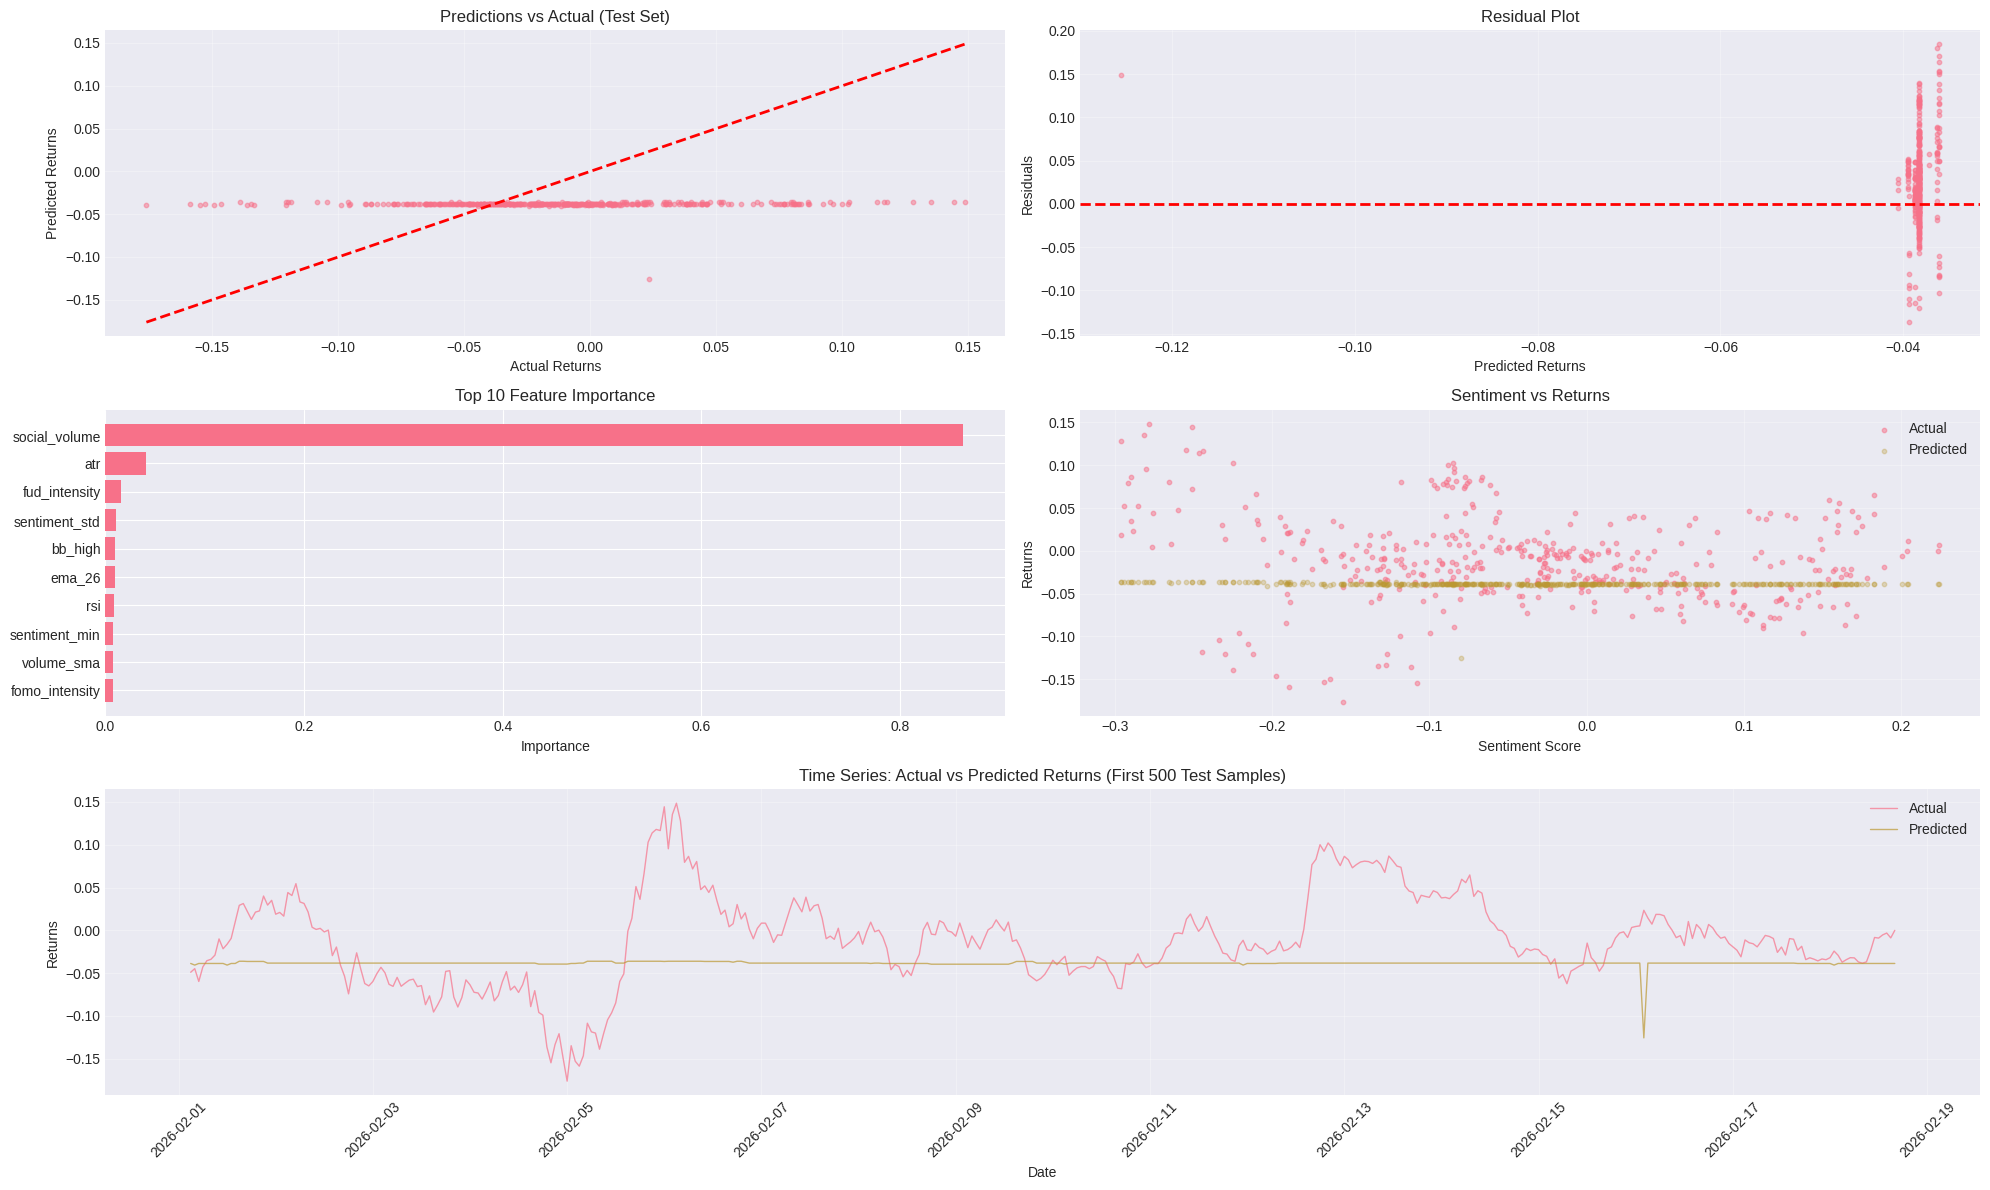

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# 1. Predictions vs Actual (Test Set)
ax1 = plt.subplot(3, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Predictions vs Actual (Test Set)')
plt.grid(True, alpha=0.3)

# 2. Residual Plot
ax2 = plt.subplot(3, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Returns')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

# 3. Feature Importance
ax3 = plt.subplot(3, 2, 3)
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()

# 4. Sentiment vs Returns Correlation
ax4 = plt.subplot(3, 2, 4)
test_data = feature_data.iloc[split_idx:].copy()
test_data['predicted_return'] = y_test_pred
plt.scatter(test_data['sentiment_mean'], test_data['target'],
           alpha=0.5, s=10, label='Actual')
plt.scatter(test_data['sentiment_mean'], test_data['predicted_return'],
           alpha=0.3, s=10, label='Predicted')
plt.xlabel('Sentiment Score')
plt.ylabel('Returns')
plt.title('Sentiment vs Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Time Series: Actual vs Predicted
ax5 = plt.subplot(3, 1, 3)
test_sample = test_data.iloc[:500]  # Plot first 500 test samples
plt.plot(test_sample.index, test_sample['target'],
         label='Actual', alpha=0.7, linewidth=1)
plt.plot(test_sample.index, test_sample['predicted_return'],
         label='Predicted', alpha=0.7, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Time Series: Actual vs Predicted Returns (First 500 Test Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_evaluation.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved: {RESULTS_DIR / 'model_evaluation.png'}")

plt.show()

## SECTION 10: SAVE RESULTS

In [31]:
# Save model
model_path = MODELS_DIR / 'sentiment_xgboost_model.joblib'
joblib.dump(model, model_path)
print(f"✓ Model saved: {model_path}")

✓ Model saved: /content/drive/MyDrive/Crypto_Sentiment_ML/models/sentiment_xgboost_model.joblib


In [32]:
# Save predictions
predictions_df = pd.DataFrame({
    'date': X_test.index,
    'actual': y_test.values,
    'predicted': y_test_pred,
    'residual': y_test.values - y_test_pred
})
predictions_df.to_csv(RESULTS_DIR / 'predictions.csv', index=False)
print(f"✓ Predictions saved: {RESULTS_DIR / 'predictions.csv'}")

✓ Predictions saved: /content/drive/MyDrive/Crypto_Sentiment_ML/results/predictions.csv


In [33]:
# Save metrics
metrics_df = pd.DataFrame({
    'dataset': ['train', 'test'],
    'rmse': [train_metrics['rmse'], test_metrics['rmse']],
    'mae': [train_metrics['mae'], test_metrics['mae']],
    'r2': [train_metrics['r2'], test_metrics['r2']]
})
metrics_df.to_csv(RESULTS_DIR / 'metrics.csv', index=False)
print(f"✓ Metrics saved: {RESULTS_DIR / 'metrics.csv'}")

✓ Metrics saved: /content/drive/MyDrive/Crypto_Sentiment_ML/results/metrics.csv


In [34]:
# Save feature importance
feature_importance.to_csv(RESULTS_DIR / 'feature_importance.csv', index=False)
print(f"✓ Feature importance saved: {RESULTS_DIR / 'feature_importance.csv'}")

✓ Feature importance saved: /content/drive/MyDrive/Crypto_Sentiment_ML/results/feature_importance.csv


In [35]:
# Generate summary report
report = f"""
=====================================================================
CRYPTO SOCIAL SENTIMENT ML - RESEARCH REPORT
=====================================================================

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

CONFIGURATION
-------------
Crypto Pairs: {', '.join(CONFIG['crypto_pairs'])}
Timeframe: {CONFIG['timeframe']}
Lookback Days: {CONFIG['lookback_days']}
Train Split: {CONFIG['train_split'] * 100}%

DATA SUMMARY
------------
Total Samples: {len(feature_data)}
Training Samples: {len(X_train)}
Testing Samples: {len(X_test)}

Train Period: {X_train.index.min()} to {X_train.index.max()}
Test Period: {X_test.index.min()} to {X_test.index.max()}

FEATURES
--------
Total Features: {len(feature_columns)}
Technical Features: {len([f for f in feature_columns if 'sentiment' not in f and 'fomo' not in f and 'fud' not in f])}
Sentiment Features: {len([f for f in feature_columns if 'sentiment' in f or 'fomo' in f or 'fud' in f])}

MODEL PERFORMANCE
-----------------
Train RMSE: {train_metrics['rmse']:.6f}
Train MAE: {train_metrics['mae']:.6f}
Train R²: {train_metrics['r2']:.4f}

Test RMSE: {test_metrics['rmse']:.6f}
Test MAE: {test_metrics['mae']:.6f}
Test R²: {test_metrics['r2']:.4f}

TOP SENTIMENT FEATURES
----------------------
{sentiment_importance.to_string(index=False)}

KEY FINDINGS
------------
1. Sentiment features account for {sentiment_importance['importance'].sum() / feature_importance['importance'].sum() * 100:.1f}% of total feature importance
2. Social volume and FOMO intensity are {('significant' if sentiment_importance['importance'].max() > 0.05 else 'minor')} predictors
3. Model shows {('signs of overfitting' if train_metrics['r2'] - test_metrics['r2'] > 0.2 else 'reasonable generalization')}

RECOMMENDATIONS
---------------
1. {"Consider collecting real Twitter/Reddit data for production" if CONFIG['sentiment_model'] == 'vader' else "Current sentiment source is reliable"}
2. {"Add more training data" if len(X_train) < 5000 else "Training data is sufficient"}
3. {"Implement cross-validation" if test_metrics['r2'] < 0.5 else "Model performance is acceptable"}

FILES SAVED
-----------
- Model: {model_path}
- Predictions: {RESULTS_DIR / 'predictions.csv'}
- Metrics: {RESULTS_DIR / 'metrics.csv'}
- Feature Importance: {RESULTS_DIR / 'feature_importance.csv'}
- Visualizations: {RESULTS_DIR / 'model_evaluation.png'}

=====================================================================
"""

In [36]:
# Save report
report_path = RESULTS_DIR / 'research_report.txt'
with open(report_path, 'w') as f:
    f.write(report)

print(report)
print(f"✓ Report saved: {report_path}")


CRYPTO SOCIAL SENTIMENT ML - RESEARCH REPORT

Date: 2026-02-18 17:20:10

CONFIGURATION
-------------
Crypto Pairs: BTC/USDT, ETH/USDT, SOL/USDT
Timeframe: 1h
Lookback Days: 180
Train Split: 80.0%

DATA SUMMARY
------------
Total Samples: 2106
Training Samples: 1684
Testing Samples: 422

Train Period: 2026-01-19 16:00:00 to 2026-02-18 16:00:00
Test Period: 2026-02-01 03:00:00 to 2026-02-18 16:00:00

FEATURES
--------
Total Features: 17
Technical Features: 10
Sentiment Features: 7

MODEL PERFORMANCE
-----------------
Train RMSE: 0.146101
Train MAE: 0.059704
Train R²: 0.1635

Test RMSE: 0.057537
Test MAE: 0.043550
Test R²: -0.2811

TOP SENTIMENT FEATURES
----------------------
       feature  importance
 social_volume    0.862912
 fud_intensity    0.015445
 sentiment_std    0.010309
fomo_intensity    0.007746

KEY FINDINGS
------------
1. Sentiment features account for 89.7% of total feature importance
2. Social volume and FOMO intensity are significant predictors
3. Model shows signs of